In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import itertools

In [2]:
# connecting to gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = f"/content/gdrive/MyDrive/ds/"

Mounted at /content/gdrive


In [3]:
# reading training dataset to pandas dataframe
dataset = pd.read_csv("/content/gdrive/MyDrive/ds/weatherHistory.csv")
# show general info about the original dataframe 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [4]:
# converting date strings into numeric timestamps ignoring years notation
def get_timestamp(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S.%f %z')
    timestamp = date_obj.month*100 + date_obj.day
    return timestamp 

# generating timestamps to distinguish Seasons of the year 
dataset["Season"] = dataset["Formatted Date"].apply(get_timestamp)
# sorting dataframe rows by the month-day timestamps
dataset.sort_values('Season', ascending=True, inplace=True)

In [5]:
# selecting columns of numerical type for the linear regression analysis 
data_num = dataset.drop(["Daily Summary", "Precip Type", "Summary", "Formatted Date"], axis=1)
# show general info of the resulting dataframe subset
data_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96453 entries, 90576 to 72212
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Temperature (C)           96453 non-null  float64
 1   Apparent Temperature (C)  96453 non-null  float64
 2   Humidity                  96453 non-null  float64
 3   Wind Speed (km/h)         96453 non-null  float64
 4   Wind Bearing (degrees)    96453 non-null  float64
 5   Visibility (km)           96453 non-null  float64
 6   Loud Cover                96453 non-null  float64
 7   Pressure (millibars)      96453 non-null  float64
 8   Season                    96453 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 7.4 MB


In [6]:
# show per-column description of numerical data
data_num.describe()

Temperature (C)  Apparent Temperature (C)      Humidity  \
count     96453.000000              96453.000000  96453.000000   
mean         11.932678                 10.855029      0.734899   
std           9.551546                 10.696847      0.195473   
min         -21.822222                -27.716667      0.000000   
25%           4.688889                  2.311111      0.600000   
50%          12.000000                 12.000000      0.780000   
75%          18.838889                 18.838889      0.890000   
max          39.905556                 39.344444      1.000000   

       Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  Loud Cover  \
count       96453.000000            96453.000000     96453.000000     96453.0   
mean           10.810640              187.509232        10.347325         0.0   
std             6.913571              107.383428         4.192123         0.0   
min             0.000000                0.000000         0.000000         0.0   
25%             5.828200              116.000000         8.339800         0.0   
50%             9.965900              180.000000        10.046400         0.0   
75%            14.135800              290.000000        14.812000         0.0   
max            63.852600              359.000000        16.100000         0.0   

       Pressure (millibars)        Season  
count          96453.000000  96453.000000  
mean            1003.235956    668.106995  
std              116.969906    345.054625  
min                0.000000    101.000000  
25%             1011.900000    402.000000  
50%             1016.450000    702.000000  
75%             1021.090000   1001.000000  
max             1046.380000   1231.000000

The Loud Cover column should be deleted, and the Pressure column should be cleaned from zero values considered as empty cells due to the common lower limit of 950 millibars. 

In [7]:
# removing column containing a static zero value
data_num.drop(["Loud Cover"], axis=1, inplace=True)
# removing rows containing impossible zero values
data_num = data_num.drop(data_num.loc[data_num["Pressure (millibars)"] < 900].index)
# show per-column description of numerical data
data_num.describe()

Temperature (C)  Apparent Temperature (C)      Humidity  \
count     95165.000000              95165.000000  95165.000000   
mean         11.949284                 10.878331      0.734965   
std           9.546270                 10.686240      0.195589   
min         -21.822222                -27.716667      0.000000   
25%           4.733333                  2.338889      0.600000   
50%          12.038889                 12.038889      0.780000   
75%          18.838889                 18.838889      0.890000   
max          39.905556                 39.344444      1.000000   

       Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
count       95165.000000            95165.000000     95165.000000   
mean           10.784307              187.428015        10.381889   
std             6.892106              107.405898         4.186364   
min             0.000000                0.000000         0.000000   
25%             5.812100              116.000000         8.420300   
50%             9.917600              180.000000        10.046400   
75%            14.119700              290.000000        14.908600   
max            63.852600              359.000000        16.100000   

       Pressure (millibars)        Season  
count          95165.000000  95165.000000  
mean            1016.814140    667.020281  
std                7.778356    344.388383  
min              973.780000    101.000000  
25%             1012.120000    402.000000  
50%             1016.550000    702.000000  
75%             1021.160000   1001.000000  
max             1046.380000   1231.000000

In [8]:
# show first 5 rows of the selected dataframe subset
data_num.head()

Temperature (C)  Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
90576        -8.561111                -12.072222      0.88             6.4400   
73039         1.116667                 -1.527778      0.86             8.4042   
73038         1.177778                 -2.116667      0.85            10.9319   
73037        -0.883333                 -2.588889      0.92             5.0393   
73036        -0.411111                 -2.950000      0.90             7.2450   

       Wind Bearing (degrees)  Visibility (km)  Pressure (millibars)  Season  
90576                   140.0          15.7297               1031.31     101  
73039                   111.0           5.4257               1023.21     101  
73038                   111.0           8.0017               1023.37     101  
73037                   121.0           9.7566               1023.37     101  
73036                   121.0           6.9391               1023.62     101

In [9]:
# drawing a matrix of 2D scatter plots to visualize inter-variable dependencies 
# for all columns in the selected dataframe subset 
def scatter_matrix(data, color_col="Temperature (C)", palette="rainbow", save_file=None):
  num_cols = data.columns.tolist()
  fig, axes = plt.subplots(nrows=len(num_cols), ncols=len(num_cols), figsize=(20, 20))

  # Loop through each subplot and plot scatter plot
  for i, ax_i in enumerate(axes):
      for j, ax_j in enumerate(ax_i):
          if i == j:
              ax_j.hist(data[num_cols[i]], bins=100, color="dimgray")
          else:
              ax_j.scatter(data[num_cols[i]], data[num_cols[j]], s=1, c=data[color_col], cmap=palette)
          ax_j.set_xlabel(num_cols[i])
          ax_j.set_ylabel(num_cols[j])
  plt.tight_layout()
  if save_file is not None:
    plt.savefig(f"/content/gdrive/MyDrive/ds/{save_file}.jpg")
  plt.show()

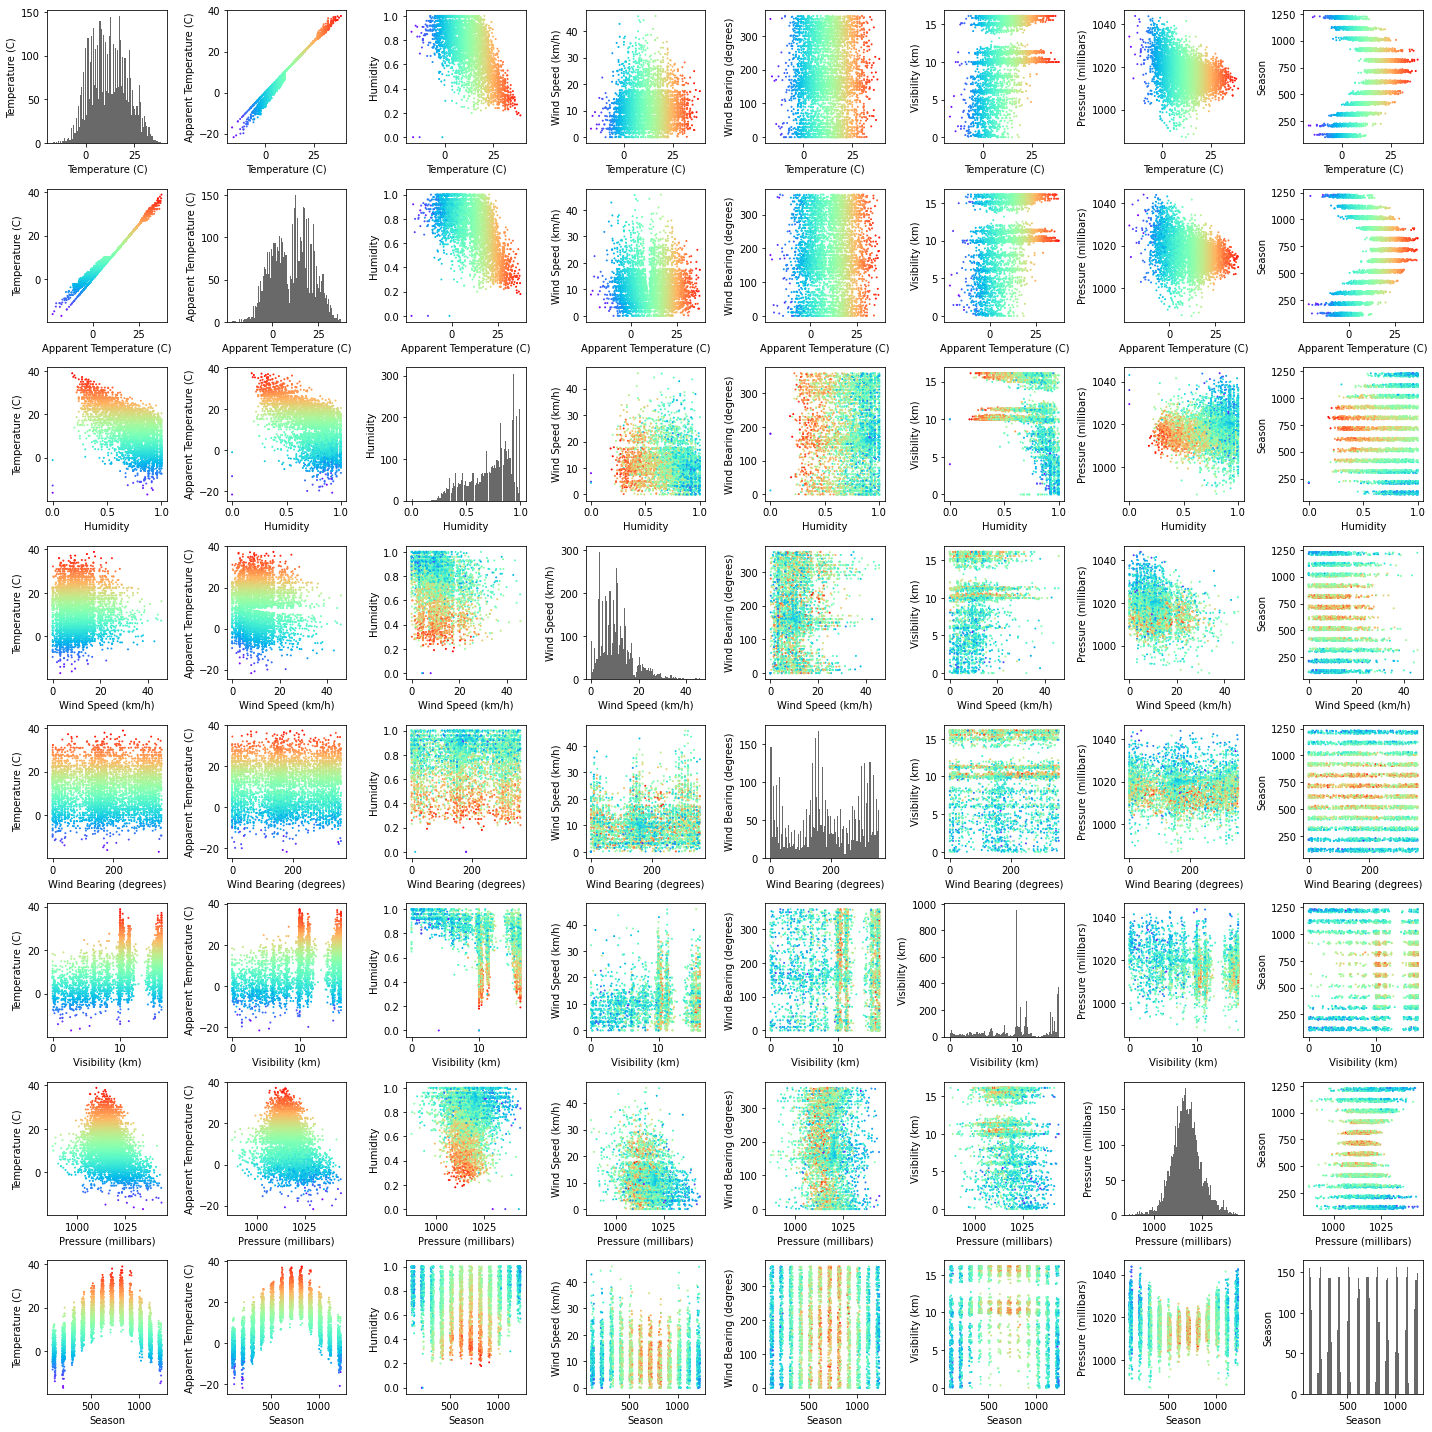

In [10]:
scatter_matrix(data_num.loc[::20, :], save_file="full_scatter_matrix")

In [11]:
# calculating the measures of Total Correlation Strength (TCS) between each column
# and all other columns in the dataframe subset selected for the analysis
tcs = data_num.corr().abs().sum(axis=1).sort_values(ascending=False)
# reordering columns in the selected dataframe
data_num = data_num[list(tcs.index)]
# displaying columns sorted by their TCS scores reduced in the diagonal values
tcs-1

Temperature (C)             2.521071
Apparent Temperature (C)    2.512137
Humidity                    1.928309
Visibility (km)             1.528236
Pressure (millibars)        1.251767
Wind Speed (km/h)           0.847956
Season                      0.669971
Wind Bearing (degrees)      0.308454
dtype: float64

Variables with high total correlation strength have a stronger linear relationship with other variables in the dataset, making them good candidates to model as output variables in a linear regression model.

On the other hand, variables with low total correlation strength have weaker linear relationships with each other, making them good predictors for a linear regression model. 

However, Wind Bearing variable is considered insignificant and ought to be removed from the selected dataset columns.

<Axes: >

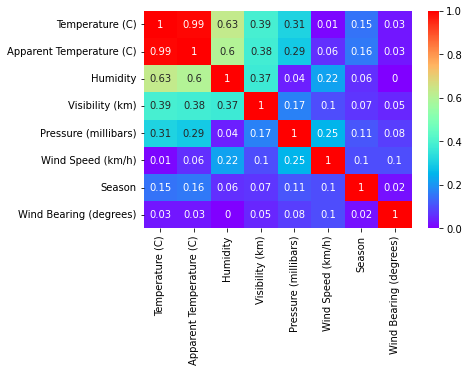

In [20]:
# creating a heatmap displaying the correlation matrix 
sns.heatmap(data_num.corr().abs().round(2), annot=True, cmap="rainbow")

Humidity, Temperature, Visibility, and Pressure columns demonstrate the most significant influence and strong connections among each other. 

While Season and Wind Speed columns show more shallow linear relationship between them and any other columns. 

There is a notable multicollinearity between Apparent Temperature and Temperature columns, which should be accounted for in the linear regression model. 

In [13]:
# removing insignificant columns and multicollinearity in the selected dataframe
data = data_num.drop(["Apparent Temperature (C)", "Wind Bearing (degrees)"], axis=1)
data_cols = list(data.columns)

# creating a list of possible output labels
labels = data_cols[:4]

# generating new correlation matrix 
data_corr = data.corr().abs().round(2)
data_corr

Temperature (C)  Humidity  Visibility (km)  \
Temperature (C)                  1.00      0.63             0.39   
Humidity                         0.63      1.00             0.37   
Visibility (km)                  0.39      0.37             1.00   
Pressure (millibars)             0.31      0.04             0.17   
Wind Speed (km/h)                0.01      0.22             0.10   
Season                           0.15      0.06             0.07   

                      Pressure (millibars)  Wind Speed (km/h)  Season  
Temperature (C)                       0.31               0.01    0.15  
Humidity                              0.04               0.22    0.06  
Visibility (km)                       0.17               0.10    0.07  
Pressure (millibars)                  1.00               0.25    0.11  
Wind Speed (km/h)                     0.25               1.00    0.10  
Season                                0.11               0.10    1.00

In [14]:
# defining a lower threshold of the correlation matrix values
lower_threshold = 0.1

# forming a list of relevant factors for the selected labels
plan = {}
for label in labels:
  plan[label] = data_corr.columns[(data_corr.columns != label) 
  & (data_corr.loc[label, :] >= lower_threshold)].tolist()

# showing label and its factors selected by the criteria of correlation matrix analysis
for label, factors in plan.items():
  print(f"{label} - {factors}")

Temperature (C) - ['Humidity', 'Visibility (km)', 'Pressure (millibars)', 'Season']
Humidity - ['Temperature (C)', 'Visibility (km)', 'Wind Speed (km/h)']
Visibility (km) - ['Temperature (C)', 'Humidity', 'Pressure (millibars)', 'Wind Speed (km/h)']
Pressure (millibars) - ['Temperature (C)', 'Visibility (km)', 'Wind Speed (km/h)', 'Season']


In [15]:
# calculating performance scores test for the suggested label-factors models

result_comb, result_model = plan.copy(), plan.copy()
# loop throught the selected labels 
for label_col in plan.keys():
  factor_cols = plan[label_col]

  rmse_train_best, rmse_val_best, r2_val_best = [], [], []
  combos_best, models_best = [], []
  iter = 0

  # converting dataframe column into its NumPy array representation
  # shape of the resulting array is matching the original form of table column
  Y = data_num[label_col].values.reshape(-1, 1)

  # loop throught the number of utilized factor variables 
  for x in range(len(factor_cols)):
    # loop throught the set of unique factor combinations 
    for subset in itertools.combinations(factor_cols, x+1):
      factors = list(subset)
      combos_best.append(factors)

      # converting dataframe columns into their NumPy arrays representations
      # shape of the resulting array is matching the original form of table columns
      X = data_num[factors].values.reshape(-1, len(factors))

      # splitting 2 array representations of data values into training (70%) and 
      # validation (30%) sets reproducible with a defined sampling seed 
      X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=1337)

      # setting linear regression model implemented in Scikit-learn
      LR_model = LinearRegression()
      # training the model to predict Y outputs based on the X inputs  
      LR_model.fit(X_train, Y_train)
      models_best.append(LR_model)

      # estimating Y outputs based on the training X inputs using the model 
      Y_pred = LR_model.predict(X_train)
      # calculating MSE between the genuine and the predicted Y coordinate values
      mse = mean_squared_error(Y_train, Y_pred)
      # calculating root MSE to measure performance of the trained regression model
      rmse_t = np.sqrt(mse)
      rmse_train_best.append(rmse_t)
      # printing new performance records
      if round(rmse_t, 2) <= round(min(rmse_train_best), 2):
        print(f"{iter}\tRMSE train:\t{rmse_t}")
        print(f"Label:\t{label_col}\tFactors:\t{factors}") 
      
      # predicting Y outputs using the trained model based on the validation X inputs 
      Y_pred = LR_model.predict(X_val)
      # calculating MSE between the genuine and the predicted Y coordinate values
      mse = mean_squared_error(Y_val, Y_pred)
      # calculating RMSE to measure model performance on the cross-validation dataset
      rmse_v = np.sqrt(mse)
      rmse_val_best.append(rmse_v)
      # printing new performance records
      if round(rmse_v, 2) <= round(min(rmse_val_best), 2):
        print(f"{iter}\tRMSE cross-val:\t{rmse_v}")
        print(f"Label:\t{label_col}\tFactors:\t{factors}")
      
      # calculating the R-squared (coefficient of determination) score for the 
      # trained linear regression model on the cross-validation dataset
      score = r2_score(Y_val, Y_pred)
      r2_val_best.append(score)
      # printing new performance records
      if round(score, 4) >= round(max(r2_val_best), 4):
        print(f"{iter}\tR2 cross-val:\t{score}")
        print(f"Label:\t{label_col}\tFactors:\t{factors}")
      
      iter += 1

  print(f"Total amount of processed factor combinations:\t{iter}")

  # getting the best performance score indexes
  ind_t = rmse_train_best.index(min(rmse_train_best))
  ind_v = rmse_val_best.index(min(rmse_val_best))
  ind_r = r2_val_best.index(max(r2_val_best))

  # getting index of the shortest best factor combination for a final per-label result 
  result_comb[label_col] = min([combos_best[i] for i in [ind_t, ind_v, ind_r]], key=len)
  ind = combos_best.index(result_comb[label_col])
  # setting the corresponding model for the label in the resulting dictionary
  result_model[label_col] = models_best[ind]

  print(f"{label_col} - best model cross-validation performance:")
  print(f"RMSE\t{rmse_val_best[ind]}\nR2\t{r2_val_best[ind]}")

0	RMSE train:	7.398019314246577
Label:	Temperature (C)	Factors:	['Humidity']
0	RMSE cross-val:	7.3778437180304035
Label:	Temperature (C)	Factors:	['Humidity']
0	R2 cross-val:	0.4002220682856359
Label:	Temperature (C)	Factors:	['Humidity']
4	RMSE train:	7.21834008290361
Label:	Temperature (C)	Factors:	['Humidity', 'Visibility (km)']
4	RMSE cross-val:	7.1963873038558095
Label:	Temperature (C)	Factors:	['Humidity', 'Visibility (km)']
4	R2 cross-val:	0.4293620686618933
Label:	Temperature (C)	Factors:	['Humidity', 'Visibility (km)']
5	RMSE train:	6.873008448670756
Label:	Temperature (C)	Factors:	['Humidity', 'Pressure (millibars)']
5	RMSE cross-val:	6.862804515360536
Label:	Temperature (C)	Factors:	['Humidity', 'Pressure (millibars)']
5	R2 cross-val:	0.4810388636013384
Label:	Temperature (C)	Factors:	['Humidity', 'Pressure (millibars)']
10	RMSE train:	6.76966527282062
Label:	Temperature (C)	Factors:	['Humidity', 'Visibility (km)', 'Pressure (millibars)']
10	RMSE cross-val:	6.756554599720952

In [16]:
# comparing initial choice and calculated by metrics result
print(f"\tBased on the correlation matrix analysis:")
for label, factors in plan.items():
  print(f"{label} - {factors}")

print(f"\tBased on the linear regression model performance:")
for label, factors in result_comb.items():
  print(f"{label} - {factors}")

	Based on the correlation matrix analysis:
Temperature (C) - ['Humidity', 'Visibility (km)', 'Pressure (millibars)', 'Season']
Humidity - ['Temperature (C)', 'Visibility (km)', 'Wind Speed (km/h)']
Visibility (km) - ['Temperature (C)', 'Humidity', 'Pressure (millibars)', 'Wind Speed (km/h)']
Pressure (millibars) - ['Temperature (C)', 'Visibility (km)', 'Wind Speed (km/h)', 'Season']
	Based on the linear regression model performance:
Temperature (C) - ['Humidity', 'Visibility (km)', 'Pressure (millibars)', 'Season']
Humidity - ['Temperature (C)', 'Visibility (km)', 'Wind Speed (km/h)']
Visibility (km) - ['Temperature (C)', 'Humidity', 'Pressure (millibars)', 'Wind Speed (km/h)']
Pressure (millibars) - ['Temperature (C)', 'Wind Speed (km/h)', 'Season']


The combinations of factors per label are identical, thus the initial analytical suggestions have been confirmed by the computational metric tests (train and valid RMSE, R2) done on all possible combinations of factors relevant to the selected labels to identify the best set of label-specific input variables.   

The **R-squared** score is a measure of how well the regression line (or curve) fits the actual data points, and represents the proportion of the variance 
in `Y_test` that is predictable from `X_test`. 

It's calculated by comparing the variation of `Y_test` from their mean (total sum of squares, or TSS) to the variation of `Y_pred` from `Y_test` (residual sum of squares, or RSS).

The formula for R2:

$R^2 = 1 - \frac{RSS}{TSS}$

$TSS = \sum\limits_{i=1}^n(y_i - \bar{y})^2$

$RSS = \sum\limits_{i=1}^n(y_i - \hat{y_i})^2$

where $y_i$ is the actual output value, $\bar{y}$ is the mean of the actual output values `Y_test`, and $\hat{y_i}$ is the predicted output value.

The $R^2$ score ranges from 0 to 1:

**0** - the model is no better than predicting the mean of `Y_test`;

**1** - perfect fit of the model to the data, where all the variation in `Y_test` is explained by `Y_pred`.

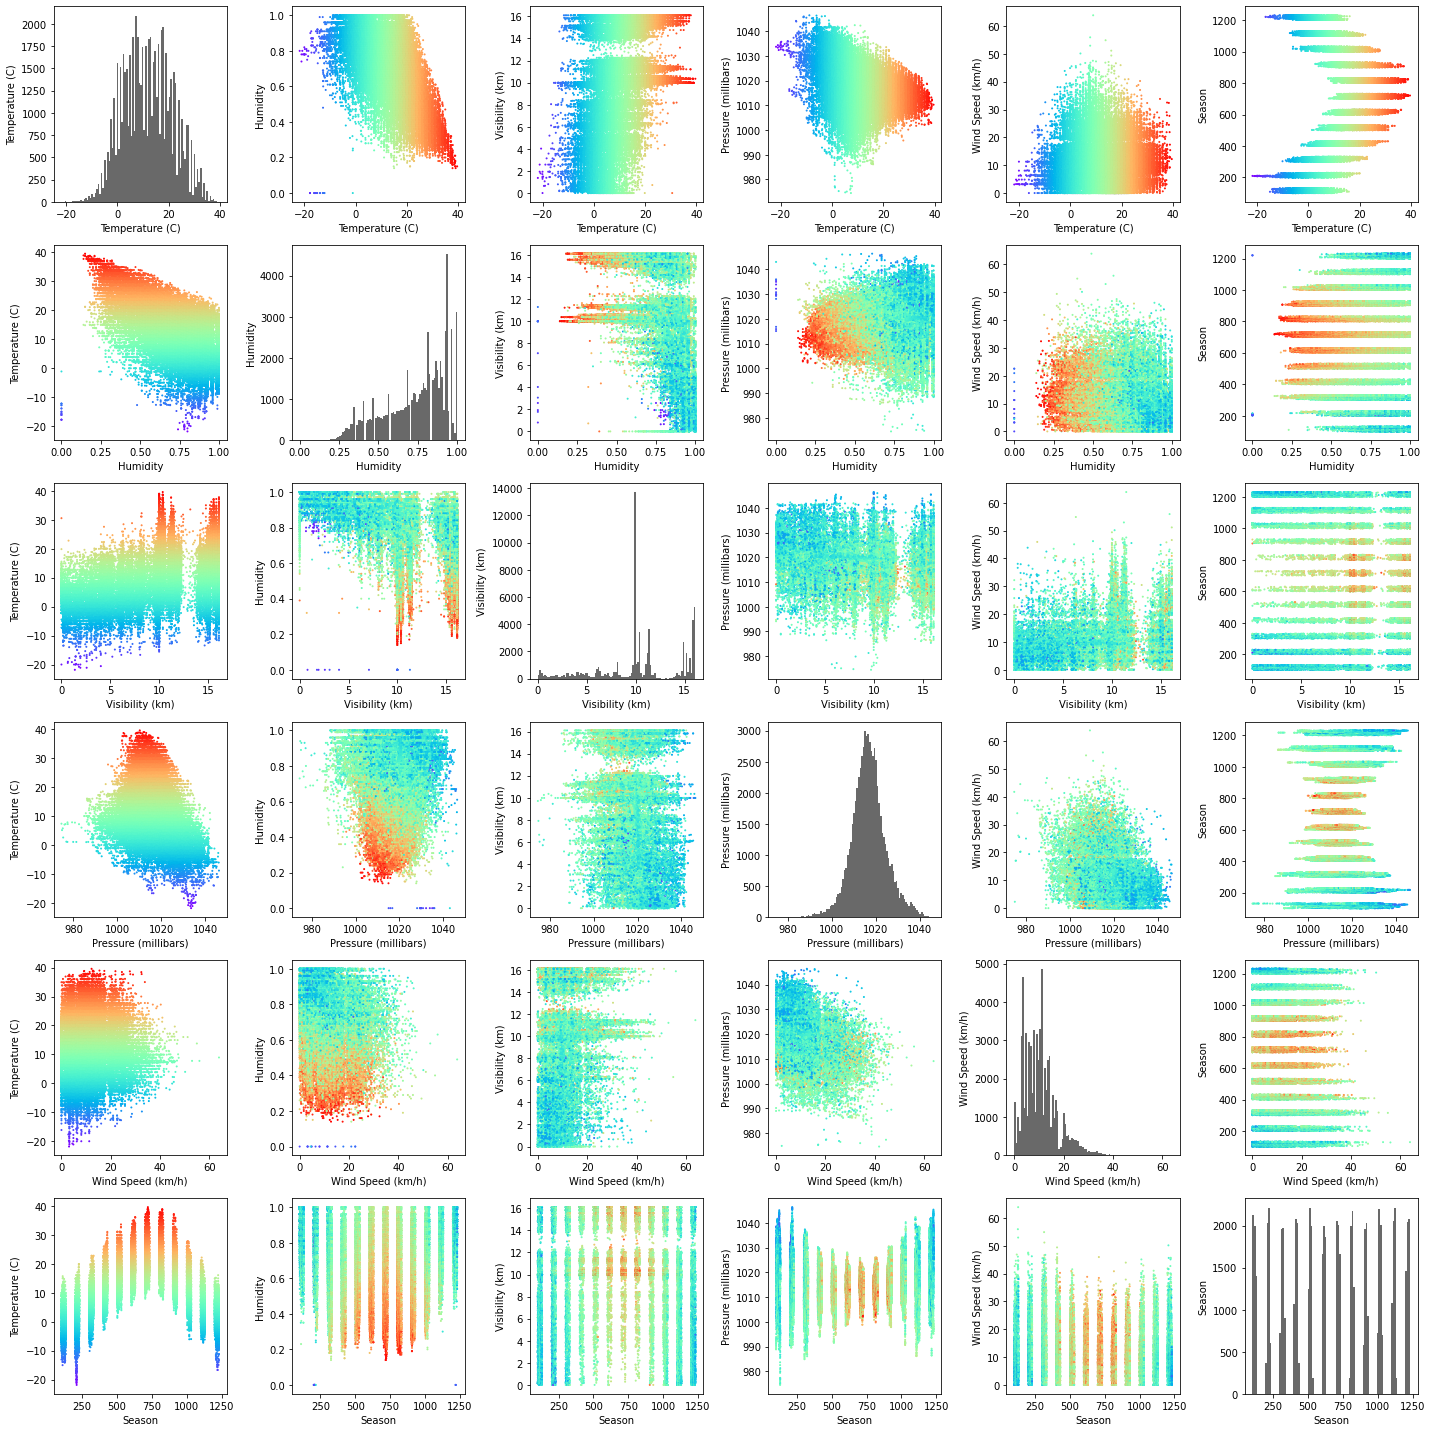

In [17]:
# plotting matrix of 2D scatter plots for the training dataset formed from  
# the final dataframe subset of raw labels and factors 
I = data.index.values.reshape(-1, 1)
Y = data[labels].values.reshape(-1, len(labels))
I_train, I_val, Y_train, Y_val = train_test_split(I, Y, test_size=0.3, 
                                                        random_state=1337)
scatter_matrix(data[data.index.isin(I_train.flatten())], save_file="raw_scatter_matrix")

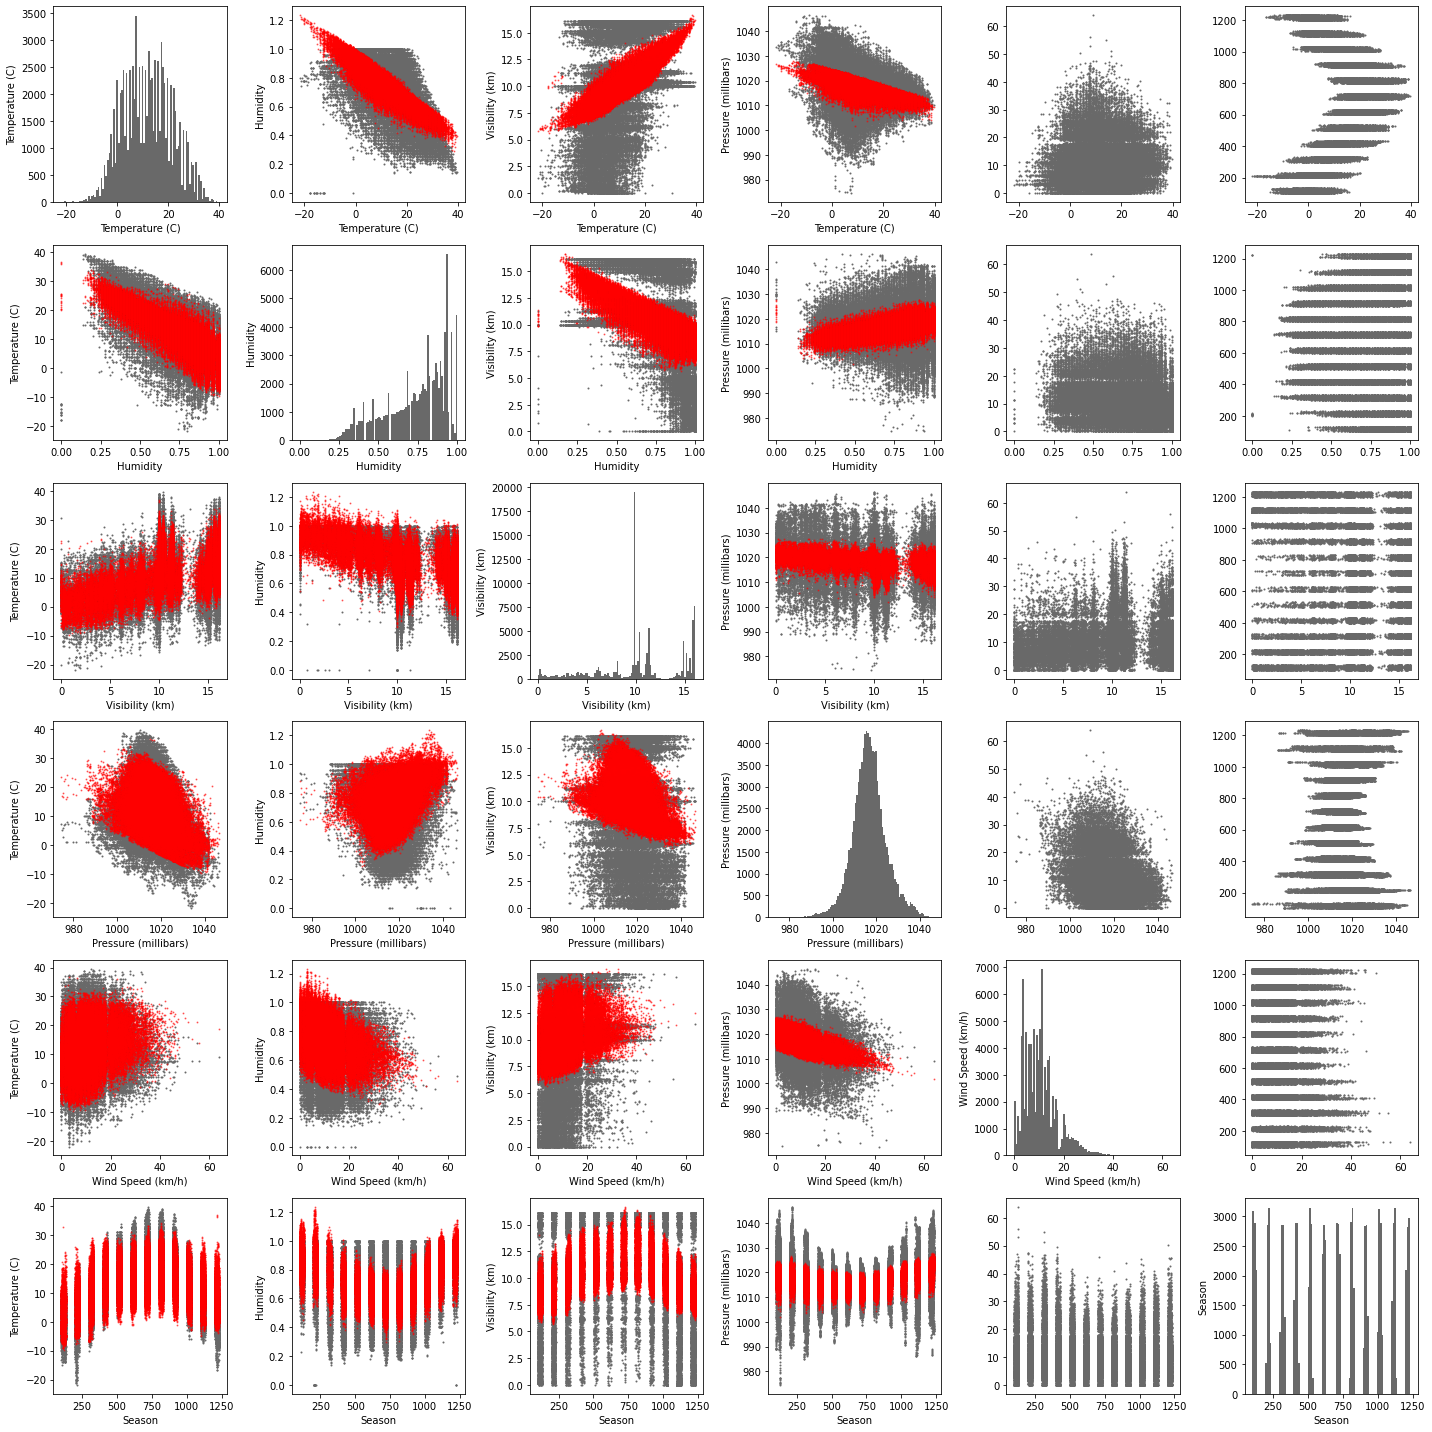

In [18]:
# drawing a matrix of 2D scatter plots to visualize inter-variable dependencies 
# for the label columns in the final dataframe subset, and show predicted values
num_cols = data.columns.tolist()
fig, axes = plt.subplots(nrows=len(num_cols), ncols=len(num_cols), figsize=(20, 20))

# Loop through each subplot and plot scatter plot
for i, ax_i in enumerate(axes):
  i_data = data[num_cols[i]].values.reshape(-1, 1)
  for j, ax_j in enumerate(ax_i):
    if i == j:
      ax_j.hist(data[num_cols[i]], bins=100, color="dimgray")
    else:
      yax_col_label = num_cols[j]
      # plotting original data on the scatter plot
      j_data = data_num[yax_col_label].values.reshape(-1, 1)
      i_train, i_val, j_train, j_val = train_test_split(i_data, j_data, 
                                                          test_size=0.3,
                                                          random_state=1337)
      ax_j.scatter(i_train, j_train, s=1, color="dimgray")

      # skip for labels without models
      if not yax_col_label in result_comb.keys():
        continue

      # plotting points predicted on the training sequence of all factors 
      # into separate per-factor subplot 
      input_col_labels = result_comb[yax_col_label]
      Y = data_num[yax_col_label].values.reshape(-1, 1)
      X = data_num[input_col_labels].values.reshape(-1, len(input_col_labels))
      LR_model = result_model[yax_col_label] 

      X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, 
                                                        random_state=1337)
      
      Y_pred = LR_model.predict(X_train)
      ax_j.scatter(i_train, Y_pred, color="red", s=1, alpha=0.5)
    ax_j.set_xlabel(num_cols[i])
    ax_j.set_ylabel(num_cols[j])
plt.tight_layout()
plt.savefig("/content/gdrive/MyDrive/ds/final_scatter_matrix.jpg")
plt.show()